# Analysis

Take the best mock build in `main.ipynb` and run some analysis on it.

## Imports etc

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import clustering as c
import data as d

import halotools.mock_observables
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [2]:
sim_data = np.load("mocks/new.npy")
sim_size = 1000

# sim_data = sim_data[np.log10(sim_data["stellar_mass"]) > 11]

sats = sim_data[sim_data["upid"] != -1]
cens = sim_data[sim_data["upid"] == -1]
assert len(sim_data) == len(sats) + len(cens)

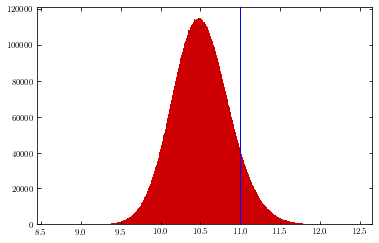

In [3]:
_, ax = plt.subplots()
ax.hist(np.log10(cens["stellar_mass"]), bins="fd")
complete_cut = 1e11
ax.axvline(np.log10(complete_cut), color="blue")

cens_complete = cens[cens["stellar_mass"] > complete_cut]
sats_complete = sats[sats["stellar_mass"] > complete_cut]
sim_data_complete = sim_data[sim_data["stellar_mass"] > complete_cut]

# Mag gap 2

In [46]:
s_cens = np.sort(cens[
    cens["Mpeak"] > 1e14 # We can't go much lower than this without getting some halos without sats
], order="id")

In [47]:
s_sats = np.sort(sats, order=["upid", "stellar_mass"])
idx = np.searchsorted(s_sats["upid"], s_cens["id"], side="right") - 1

assert np.all(s_sats[idx]["upid"] == s_cens["id"])
s_sats = s_sats[idx]
# We now have a bunch of cens and the largest sat in some of the largest halos.

0.7454575596816976


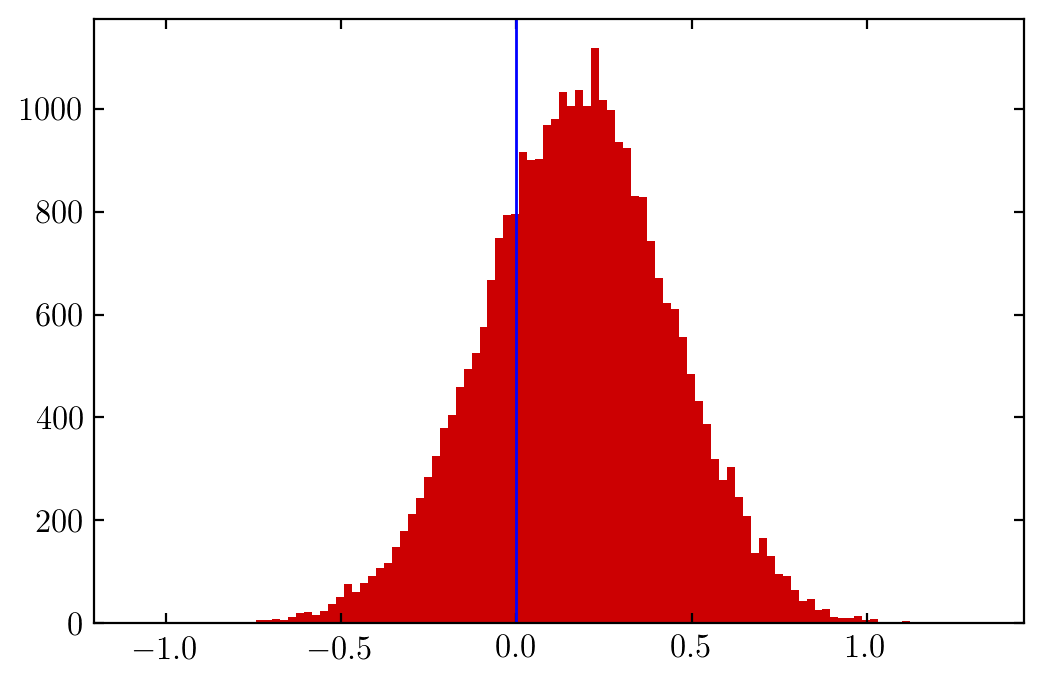

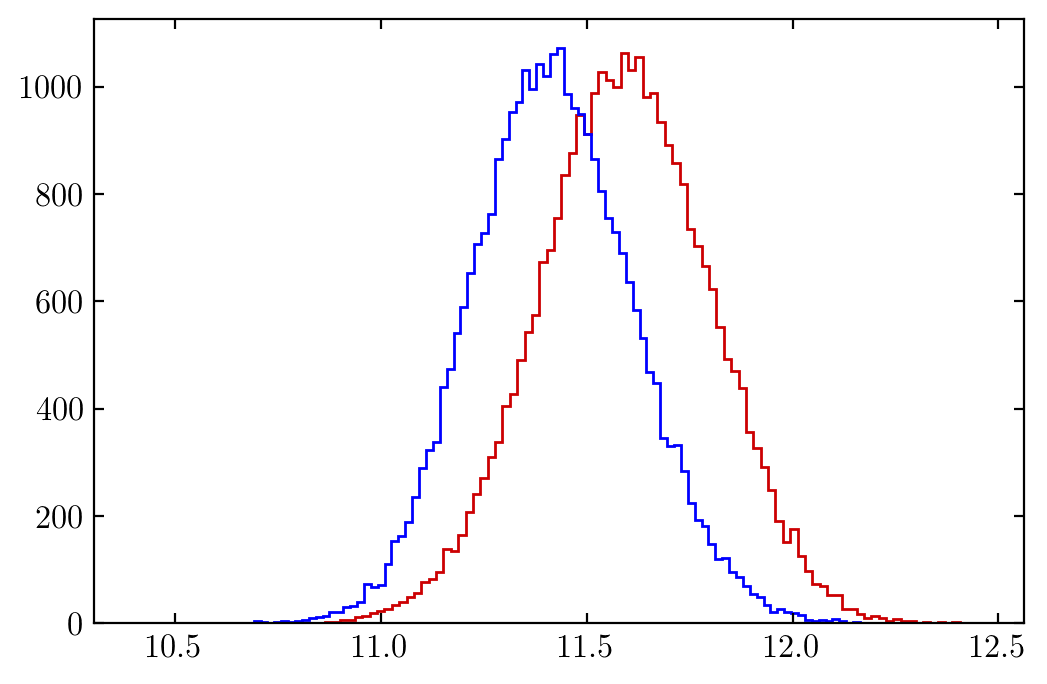

In [56]:
fig, ax = plt.subplots()
ax.hist(
    np.log10(s_cens["stellar_mass"]) - np.log10(s_sats["stellar_mass"])
)
ax.axvline(0, color="blue")
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/mag_gap1.png", dpi=300)
print(np.count_nonzero(
    np.log10(s_cens["stellar_mass"]) > np.log10(s_sats["stellar_mass"])
)/len(s_cens))

fig, ax = plt.subplots()
ax.hist(np.log10(s_cens["stellar_mass"]), label="cen", histtype='step')
ax.hist(np.log10(s_sats["stellar_mass"]), label="sats", histtype='step')
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/mag_gap2.png", dpi=300)

# Magnitude Gap

In [55]:
sats = np.sort(sats, order=["upid", "stellar_mass"])
cens = np.sort(cens, order="id")

In [56]:
idx = np.searchsorted(sats["upid"], cens["id"], side="right") - 1

In [57]:
actual_match = (sats[idx]["upid"] == cens["id"]) # Ignore cases where there are no satellites. Common as we have a high mass cut

idx = idx[actual_match]
cens_with_sats = cens[actual_match]
assert np.all(cens_with_sats["id"] == sats[idx]["upid"])

In [60]:
i = 151
print(cens_with_sats[i])
print(sats[idx[i]])

w = np.argmin(mag_gap)

print(cens_with_sats[w])
print(sats[idx[w]])

(1833552566, -1, -1, 6.02036299e+13, 567.36, 43.97127, 38.53922, 913.08893, 173.39, -1.02, -74.41, 4.12540498e+11)
(1833552561, 1833552566, 1833552566, 2.3457282e+12, 247.34, 44.12108, 38.25917, 913.29144, -415.91, -170.57, -310.75, 2.67457491e+11)
(1899982093, -1, -1, 2.23520732e+14, 993.47, 481.5986, 205.95721, 694.01306, 119.94, -633.19, -695.27, 2.06363973e+11)
(1899982148, 1899982093, 1899982093, 8.3765678e+13, 710.51, 481.95584, 205.98206, 694.09998, -1465.09, -716.51, -317.28, 1.16888695e+12)


(array([1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 5.000e+00, 2.300e+01, 9.200e+01, 3.380e+02, 1.712e+03, 4.570e+03, 6.349e+03, 6.122e+03, 5.826e+03, 5.567e+03, 4.946e+03, 4.278e+03, 3.485e+03, 2.774e+03, 2.083e+03, 1.571e+03, 9.710e+02, 6.010e+02, 3.530e+02, 1.970e+02, 1.010e+02, 4.900e+01, 2.300e+01, 8.000e+00, 2.000e+00, 4.000e+00]),
 array([-0.26827112, -0.22884602, -0.18942091, -0.14999581, -0.11057071, -0.07114561, -0.03172051,  0.00770459,  0.0471297 ,  0.0865548 ,  0.1259799 ,  0.165405  ,  0.2048301 ,  0.24425521,  0.28368031,  0.32310541,  0.36253051,  0.40195561,  0.44138071,  0.48080582,  0.52023092,  0.55965602,  0.59908112,  0.63850622,  0.67793133,  0.71735643,  0.75678153,  0.79620663,  0.83563173,  0.87505684,  0.91448194]),
 <a list of 30 Patch objects>)

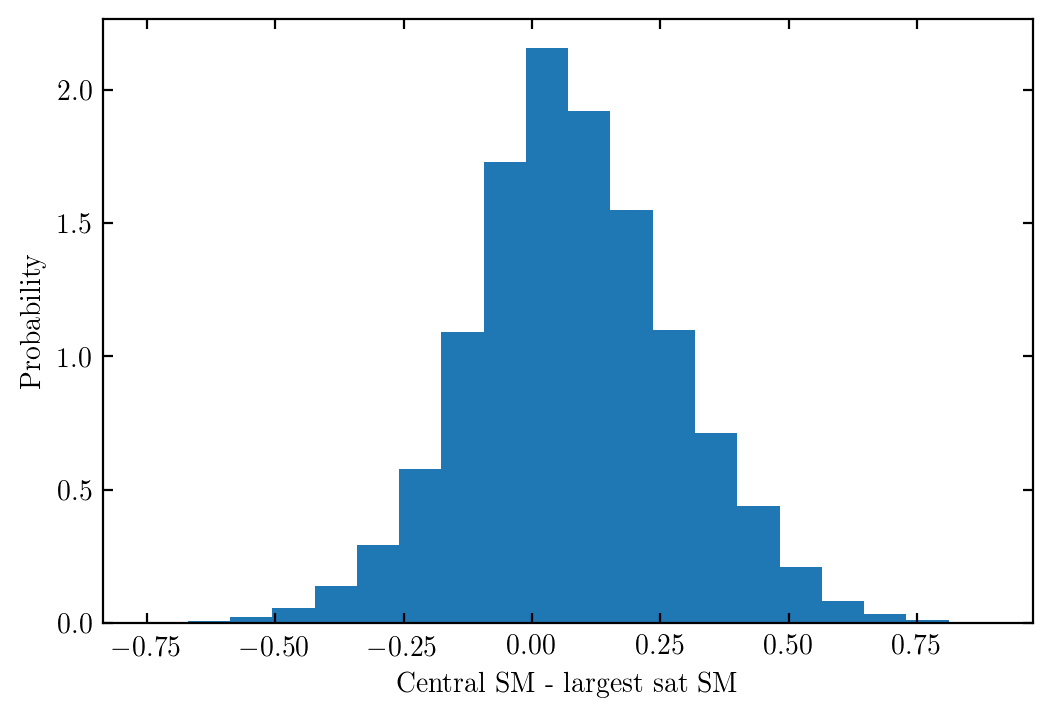

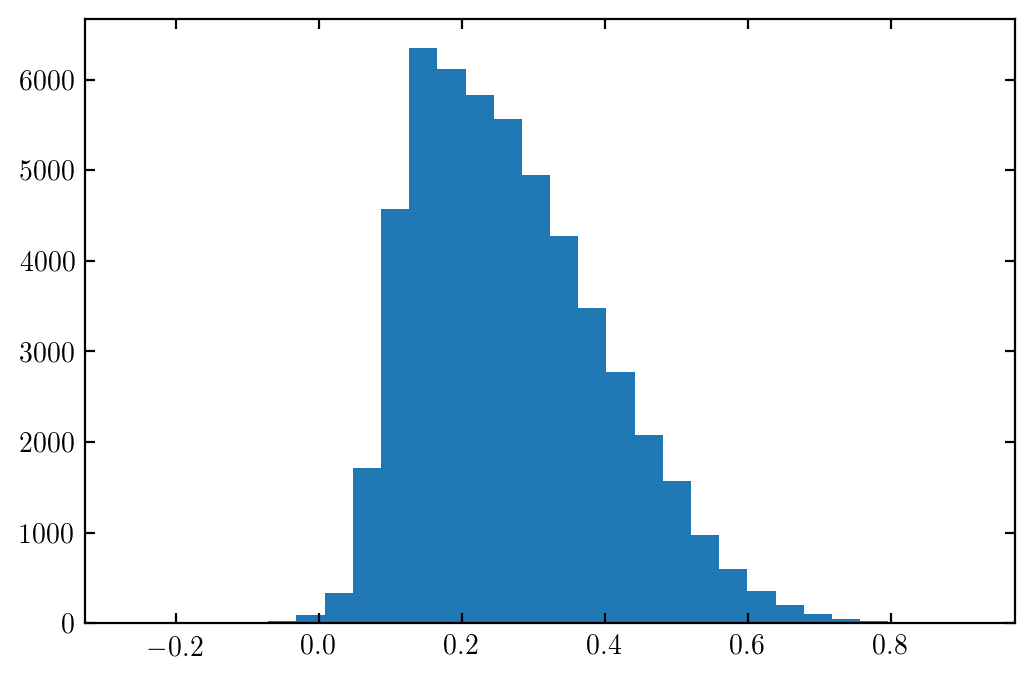

In [59]:
_, ax = plt.subplots()
mag_gap = np.log10(cens_with_sats["stellar_mass"]) - np.log10(sats[idx]["stellar_mass"])
ax.hist(mag_gap, bins=20, density=True)
ax.set(ylabel="Probability", xlabel="Central SM - largest sat SM")

_, ax = plt.subplots()
vmax_gap = np.log10(cens_with_sats["Vmax@Mpeak"]) - np.log10(sats[idx]["Vmax@Mpeak"])
ax.hist(vmax_gap, bins=30)

# Satellite Fraction

## True (Rockstar) Sat Frac Mock

In [5]:
bins = np.append(
    np.linspace(11.5, 11.9, num=9),
    np.linspace(12, 12.2, num=4),
)
bin_centers = bins[:-1] + np.diff(bins)/2

[Text(0, 0.5, 'Fraction'),
 Text(0.5, 0, 'Stellar Mass'),
 Text(0.5, 1.0, 'True (Spherical) Satellite Fraction')]

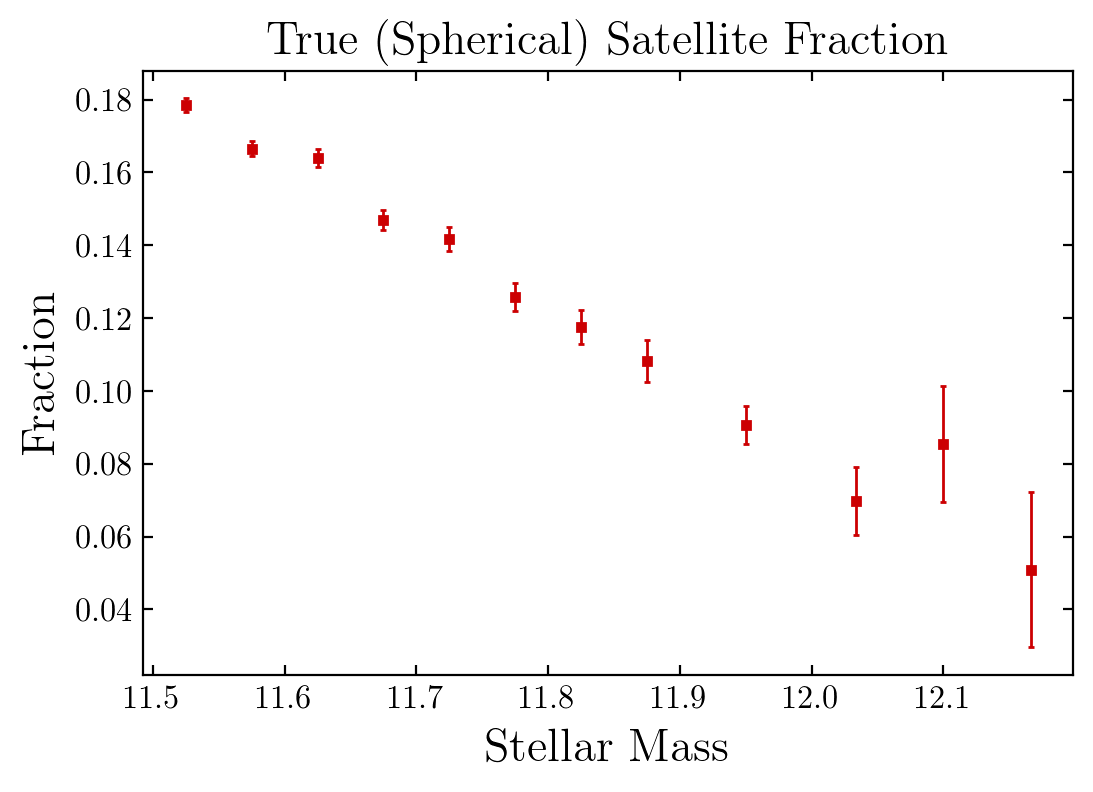

In [6]:
sats_counts, _, _ = scipy.stats.binned_statistic(sats["stellar_mass"], None, statistic="count", bins=10**bins)
cens_counts, _, _ = scipy.stats.binned_statistic(cens["stellar_mass"], None, statistic="count", bins=10**bins)

ratio = sats_counts / (cens_counts + sats_counts)
unc = ratio * np.sqrt( 1/sats_counts + 1/(sats_counts + cens_counts) )

_, ax = plt.subplots()
ax.errorbar(bin_centers, ratio, yerr=unc, ls="None", marker="s")
ax.set(title="True (Spherical) Satellite Fraction", ylabel="Fraction", xlabel="Stellar Mass")

## Cylinder Sat Frac Mock

/home/christopher/research/satellite_fraction/cb/clustering.py:224: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  np.copy(s1)[["halo_x", "halo_y", "halo_z"]].view((np.float64, 3)),#s1_pos,
/home/christopher/research/satellite_fraction/cb/clustering.py:225: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  np.copy(s2)[["halo_x", "halo_y", "halo_z"]].view((np.float64, 3)),#s2_pos,


[Text(0, 0.5, 'Fraction'),
 Text(0.5, 0, 'Stellar Mass'),
 Text(0.5, 1.0, 'Cylindrical Sat Fraction')]

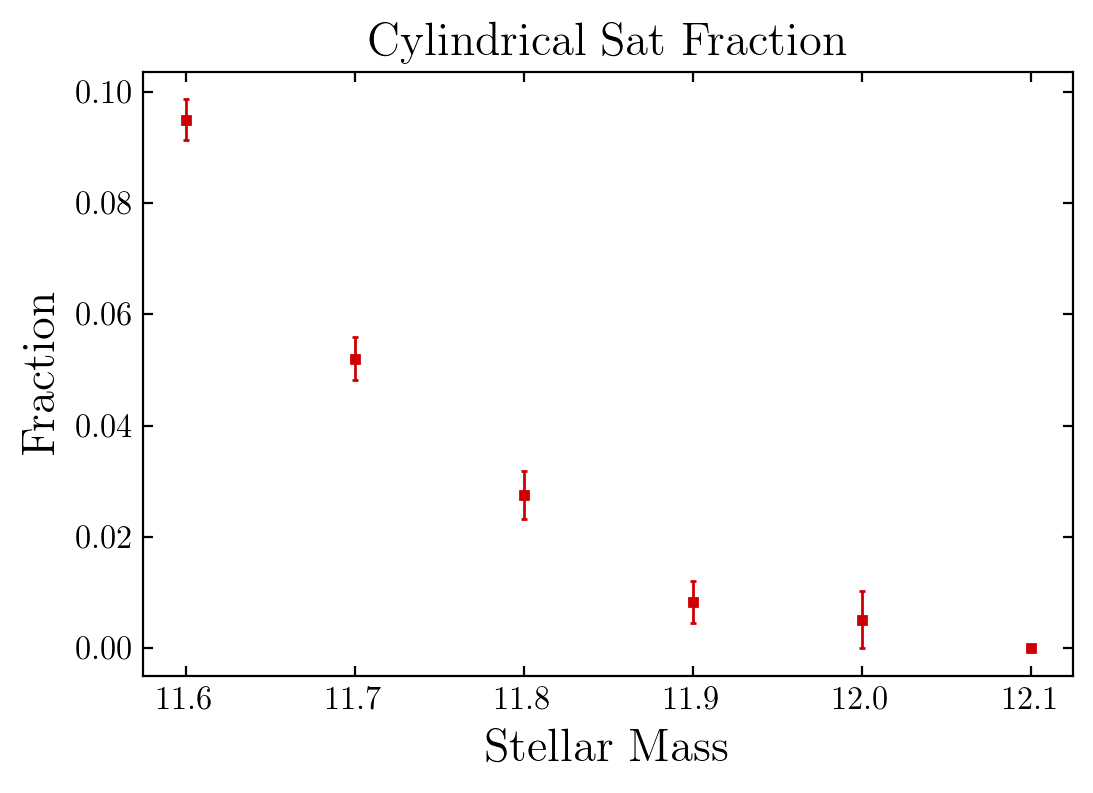

In [72]:
cen_sat_div = np.linspace(11.6, 12.1, num=6)
sat_fraction, sat_fraction_err = np.zeros_like(cen_sat_div), np.zeros_like(cen_sat_div)

for i, div in enumerate(cen_sat_div):
    pairs, all_candidate_gals = c.analysis_sim_clustering(sim_data_complete, div, sim_size)
    num_sats, num_candidates = len(set(pairs["i2"])), len(all_candidate_gals)
    
    sat_fraction[i] =  num_sats / num_candidates
    if sat_fraction[i] == 0:
        sat_fraction_err[i] = 0
    else:
        sat_fraction_err[i] = sat_fraction[i] * np.sqrt( 
            1/num_sats + 1/num_candidates
        )
    
        
_, ax = plt.subplots()
ax.errorbar(cen_sat_div, sat_fraction, yerr=sat_fraction_err, ls="None", marker="s")
ax.set(title="Cylindrical Sat Fraction", ylabel="Fraction", xlabel="Stellar Mass")

## HSC

[Text(0, 0.5, 'Fraction'),
 Text(0.5, 0, 'Stellar Mass'),
 Text(0.5, 1.0, 'Cylindrical Sat Fraction')]

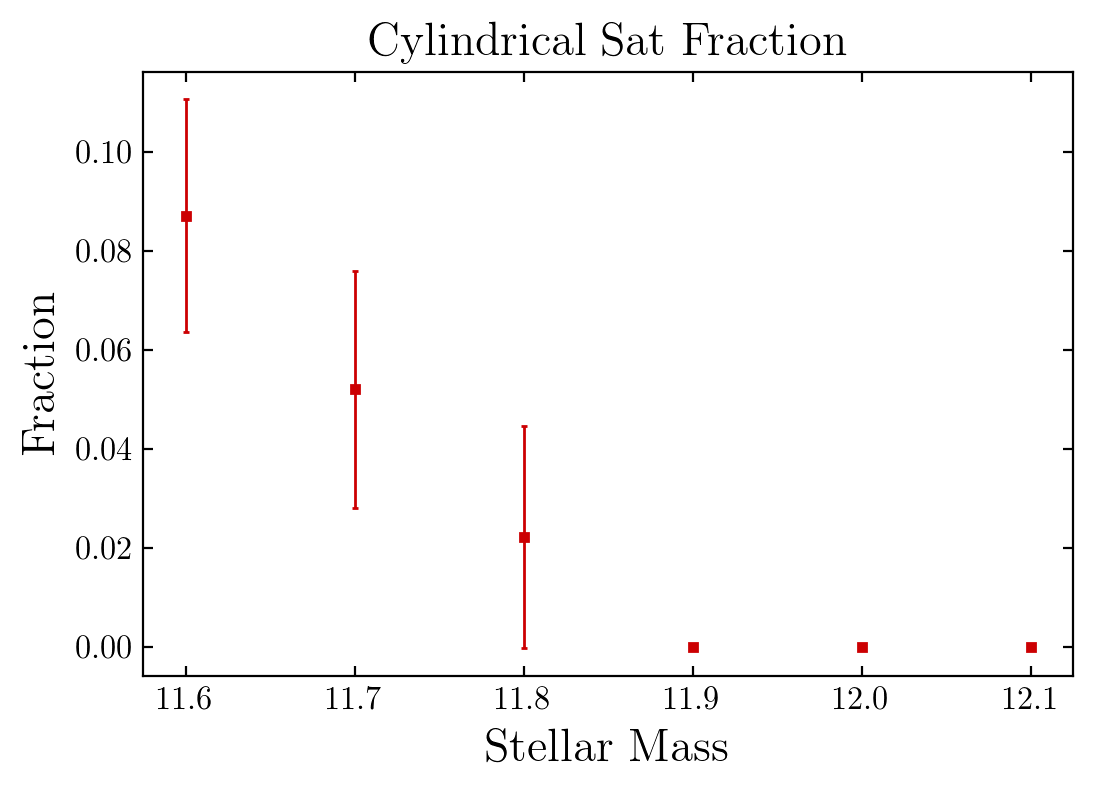

In [76]:
cen_sat_div_obs = np.linspace(11.6, 12.1, num=6)
hsc_gals = d.load_hsc_gals()
sat_fraction_obs, sat_fraction_obs_err = np.zeros_like(cen_sat_div), np.zeros_like(cen_sat_div)


for i, div in enumerate(cen_sat_div_obs):
    pairs, all_candidate_gals = c.analysis_obs_clustering(hsc_gals, div)
    num_sats, num_candidates = len(set(pairs["i2"])), len(all_candidate_gals)
    
    sat_fraction_obs[i] =  num_sats / num_candidates
    if sat_fraction_obs[i] == 0:
        sat_fraction_obs_err[i] = 0
    else:
        sat_fraction_obs_err[i] = sat_fraction_obs[i] * np.sqrt( 
            1/num_sats + 1/num_candidates
        )
        
_, ax = plt.subplots()
ax.errorbar(cen_sat_div_obs, sat_fraction_obs, yerr=sat_fraction_obs_err, ls="None", marker="s")
ax.set(title="Cylindrical Sat Fraction", ylabel="Fraction", xlabel="Stellar Mass")

## Alltogether now

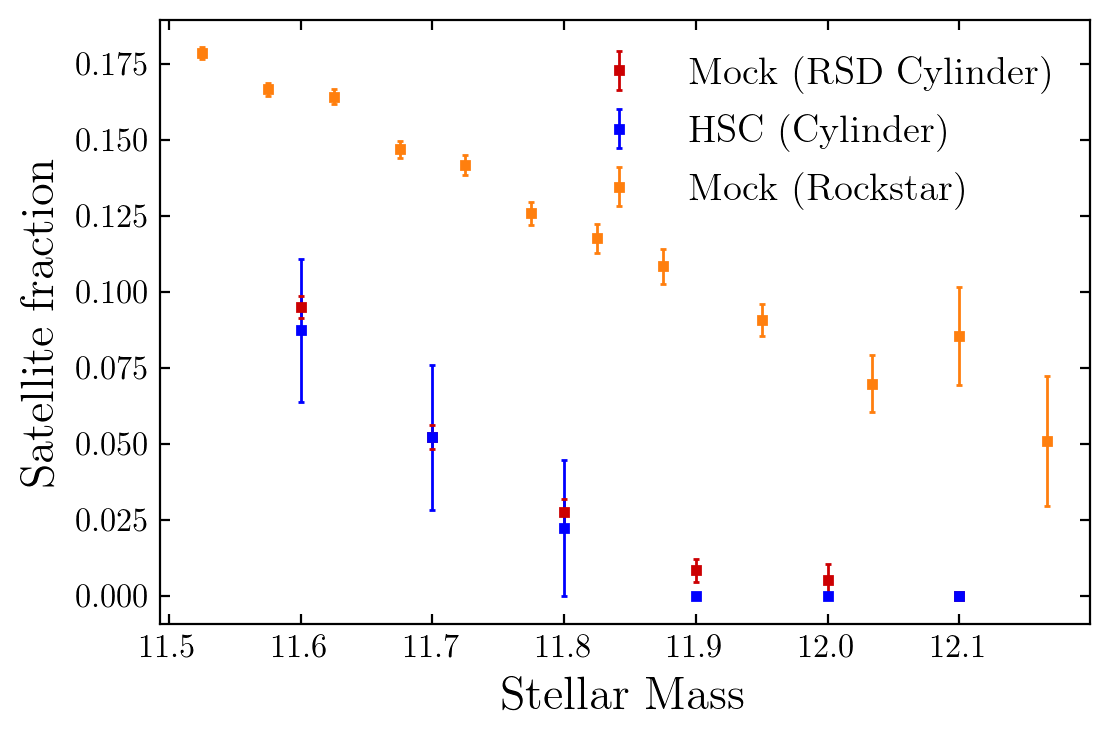

In [78]:
fig, ax = plt.subplots()
ax.errorbar(cen_sat_div, sat_fraction, yerr=sat_fraction_err, ls="None", marker="s", label="Mock (RSD Cylinder)")
ax.errorbar(cen_sat_div_obs, sat_fraction_obs, yerr=sat_fraction_obs_err, ls="None", marker="s", label="HSC (Cylinder)")
ax.errorbar(bin_centers, ratio, yerr=unc, ls="None", marker="s", label="Mock (Rockstar)")
ax.legend()
ax.set(ylabel="Satellite fraction", xlabel="Stellar Mass")

fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/sat_frac.png", dpi=300)

## Concern

There appear to be too many large sats.

In [22]:
largest_sats = sats[sats["stellar_mass"] > 10**12.17]
print(len(largest_sats))

print(largest_sats[0])
print(cens[cens["id"] == largest_sats[0]["upid"]])

5
(1838351797, 1838351236, 1838351236, 1.91161281e+14, 944.04, 59.73572, 595.54382, 165.69661, -2088.61, -174.86, -349.56, 1.51370438e+12)
[(1838351236, -1, -1, 1.31778073e+15, 1663.66, 60.53251, 595.35956, 166.26987, -534.47, -459.44, -344.49, 1.15222716e+12)]


# Scatter SMHM in Mock

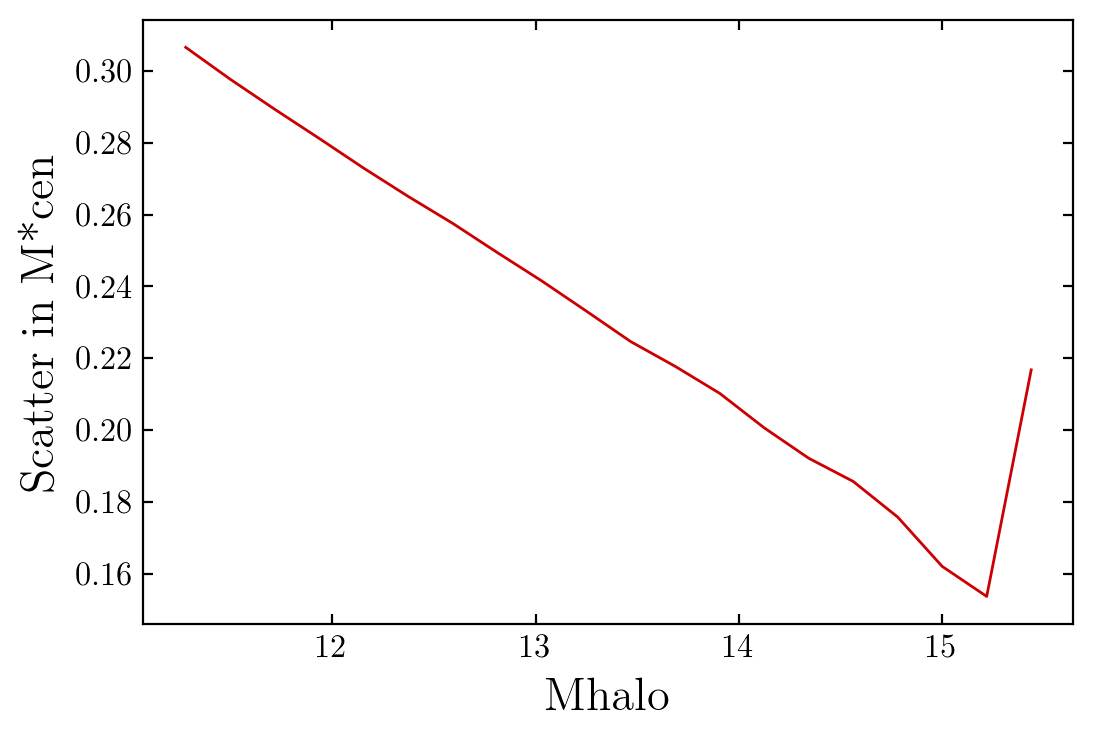

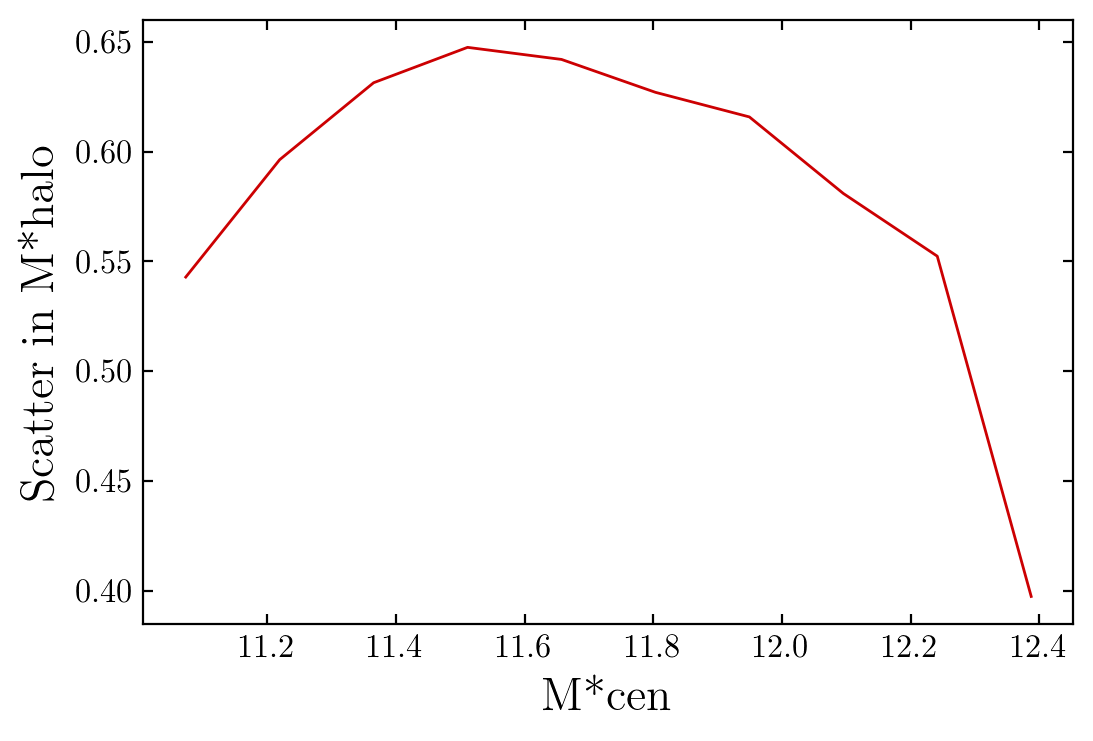

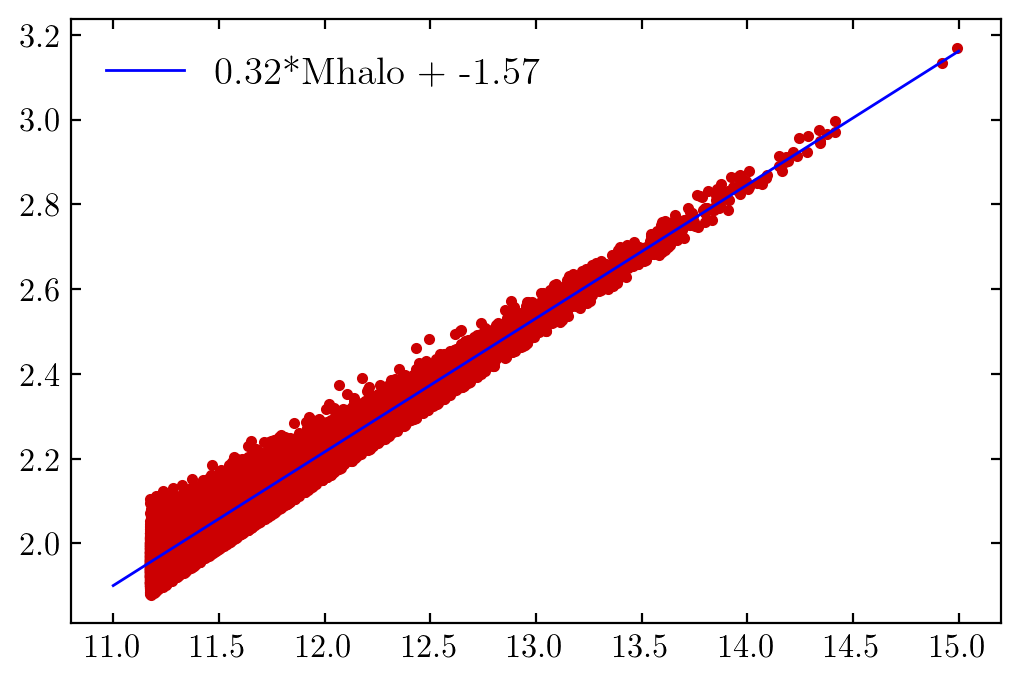

In [60]:
scatter, bin_edges, _ = scipy.stats.binned_statistic(
    np.log10(cens["Mpeak"]), 
    np.log10(cens["stellar_mass"]), 
    np.std,
    bins=20,
)
bin_centers = bin_edges[1:] - np.diff(bin_edges)/2

fig, ax = plt.subplots()
ax.plot(bin_centers, scatter)
ax.set(ylabel="Scatter in M*cen", xlabel="Mhalo")
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/scatter_mcen_mhalo.png", dpi=300)


# Exactly the same, just the other way around
scatter, bin_edges, _ = scipy.stats.binned_statistic(
    np.log10(cens_complete["stellar_mass"]), 
    np.log10(cens_complete["Mpeak"]), 
    np.std,
    bins=10,
)
bin_centers = bin_edges[1:] - np.diff(bin_edges)/2

_, ax = plt.subplots()
ax.plot(bin_centers, scatter)
ax.set(ylabel="Scatter in M*halo", xlabel="M*cen")

# And explaining why scatter in M*cen at fixed Mhalo is linear -
# Mhalo is linear with Vmax which is what we conditioned on
fig, ax = plt.subplots()
ax.scatter(
    np.log10(cens["Mpeak"][::1000]),
    np.log10(cens["Vmax@Mpeak"][::1000]),
)
regress = scipy.stats.linregress(np.log10(cens["Mpeak"]), np.log10(cens["Vmax@Mpeak"]))
mhalo = np.array([11, 15])
ax.plot(mhalo, regress.slope * mhalo + regress.intercept, color="blue", label="{:.2f}*Mhalo + {:.2f}".format(regress.slope, regress.intercept))
ax.legend()
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/mhalo_vs_vmax.png", dpi=300)

# 2pcf

We want to compare ours to this tinker paper https://arxiv.org/pdf/1607.04678.pdf

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  # This is added back by InteractiveShellApp.init_path()


Units of stellar mass are in M*


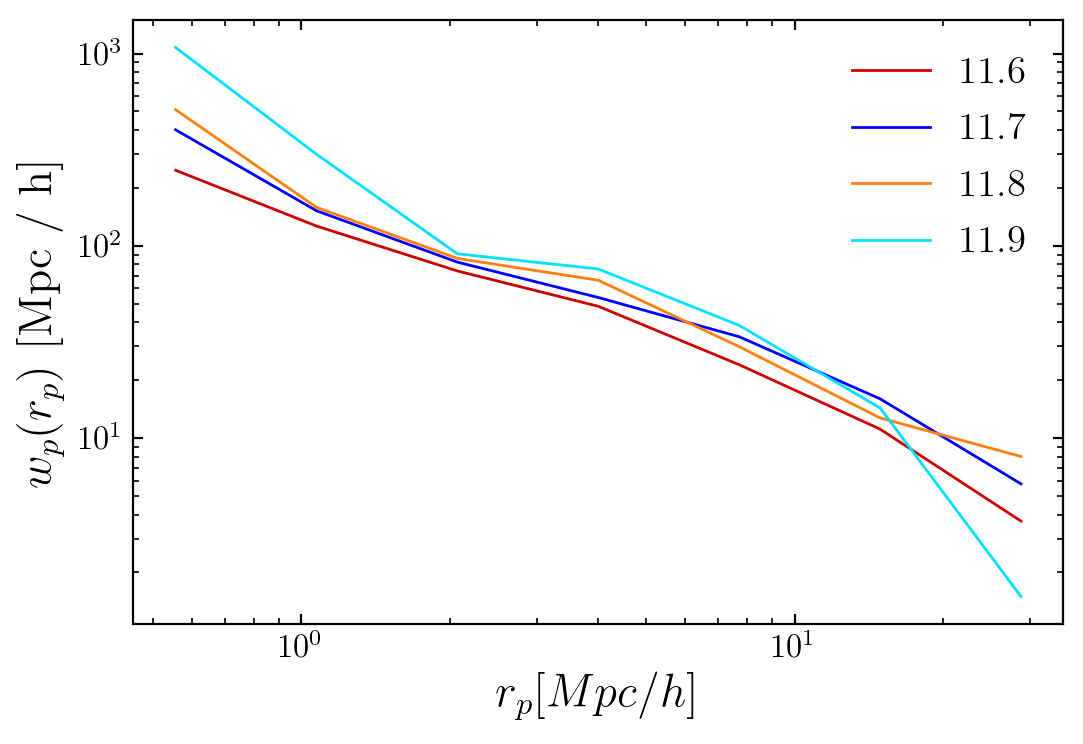

In [58]:
sm = 11.6
fig, ax = plt.subplots()
r_bins = np.geomspace(0.4, 40, num=8)
r_bins_cen = 10**( (np.log10(r_bins[:-1]) + np.log10(r_bins[1:])) / 2 )

for sm in [11.6, 11.7, 11.8, 11.9]:
    cut = sim_data_complete[
        (sim_data_complete["stellar_mass"] > 10**(sm-0.05)) &
        (sim_data_complete["stellar_mass"] < 10**(sm+0.05))
    ]
    s1 = cut[["halo_x", "halo_y", "halo_z"]].view(np.float64).reshape((-1, 3))
    assert s1[0][0] == cut[0]["halo_x"] # view is scary

    wp_rp = halotools.mock_observables.wp(s1, r_bins, 300, period=sim_size)
    ax.plot(r_bins_cen, wp_rp, label=sm)
    
ax.set(yscale="log", xscale="log", ylabel=r"$w_p(r_p)$ [Mpc / h]", xlabel="$r_p [Mpc / h]$")
ax.legend()
print("Units of stellar mass are in M*")

fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/2pcf.png", dpi=300)